<a href="https://colab.research.google.com/github/olga-terekhova/pdf-utilities/blob/main/Crop_Scale_PDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crop and scale a PDF file

- Upload a PDF file to process  
- Fill in the parameters in the section 'Parameters' below.  
- Collapse the section 'Code'.  
- Runtime - Run all or Ctrl-F9.  
- After completion, see the description of the result in the section 'Output'.  

# Parameters

In [207]:
# @title 1. Input and output pdf paths

# @markdown Enter the path to the input file:
input_pdf = "input.pdf" #@param

# @markdown Enter the path for the output file to be generated:
output_pdf = "output.pdf" #@param

In [208]:
# @title 2. Crop method

# @markdown Do you need to crop? If yes, using explicit areas to crop or using target ratio?
crop_method = "ratio" #@param ["ratio", "explicit_areas", "no crop"]

In [209]:
# @title 2.1. Ratio method parameters

# @markdown At what position to start cropping? Use inches:
left_position_in = 3.6 #@param
top_position_in = 0 #@param

# @markdown Standard size with a predefined ratio or custom ratio?
ratio_method = "custom ratio" #@param ["standard size", "custom ratio"]

# @markdown If standard size ratio, select:
standard_size = "letter landscape" #@param ["letter landscape","letter portrait", "a4 landscape", "a4 portrait"]

# @markdown If custom ratio, enter width to height ratio:
custom_ratio = 1.35 #@param





In [210]:
# @title 2.2. Explicit areas to crop

# @markdown Parameters of areas to crop in inches:
crop_left_in = 5 #@param
crop_right_in = 0 #@param
crop_top_in = 0.25 #@param
crop_bottom_in = 0 #@param


In [211]:
# @title 3. Scale method
# @markdown Need to scale after cropping?
scale_method = "scale to fit" #@param ["no scale", "scale to fit", "scale to fill"]

In [212]:
# @title 3.1. Scale parameters

# @markdown If scaling is needed, standard or custom target size?
scale_size_option = "standard size" #@param ["standard size", "custom size"]

# @markdown If standard size, select:
standard_scale_size = "letter landscape" #@param ["letter landscape","letter portrait", "a4 landscape", "a4 portrait"]

# @markdown If scale_size_option is custom, define these parameters:
custom_width_in = 11 #@param
custom_height_in = 8.5 #@param


# Code

In [213]:
# -----------------------------
# Initialization of libraries
# -----------------------------

!pip install --quiet pymupdf
import pymupdf

In [214]:
# -----------------------------
# Helpers
# -----------------------------
POINTS_PER_INCH = 72.0

def size_from_standard(name: str):
    """Return width, height (points) for standard page sizes."""
    sizes_in = {
        "letter portrait": (8.5, 11),
        "letter landscape": (11, 8.5),
        "a4 portrait": (8.27, 11.69),
        "a4 landscape": (11.69, 8.27),
    }
    w_in, h_in = sizes_in[name.lower()]
    return w_in * POINTS_PER_INCH, h_in * POINTS_PER_INCH

def print_size(label, rect):
    w_pt, h_pt = rect.width, rect.height
    w_in, h_in = w_pt / POINTS_PER_INCH, h_pt / POINTS_PER_INCH
    return str(f"{label}: {w_pt:.2f} x {h_pt:.2f} points "
          f"({w_in:.2f} x {h_in:.2f} inches)")


In [215]:
# -----------------------------
# Processing
# -----------------------------
doc = pymupdf.open(input_pdf)
new_doc = pymupdf.open()
status_output = ""

for page_number, page in enumerate(doc, start=1):
    rect = page.rect  # original page rectangle

    # ---- Report original
    status_output += f"\nPage {page_number}"
    status_output += print_size("\n Original size", rect)

    # ---- Determine crop rectangle
    if crop_method == "no crop":
        crop_rect = rect

    elif crop_method == "explicit_areas":
        crop_rect = pymupdf.Rect(
            rect.x0 + crop_left_in * POINTS_PER_INCH,
            rect.y0 + crop_top_in * POINTS_PER_INCH,
            rect.x1 - crop_right_in * POINTS_PER_INCH,
            rect.y1 - crop_bottom_in * POINTS_PER_INCH,
        )

    elif crop_method == "ratio":
        if ratio_method == "standard size":
            target_w_pt, target_h_pt = size_from_standard(standard_size)
            target_ratio = target_w_pt / target_h_pt
        else:
            target_ratio = custom_ratio

        # available width and height after left/top offset
        avail_w = rect.width - left_position_in * POINTS_PER_INCH
        avail_h = rect.height - top_position_in * POINTS_PER_INCH

        # adjust height to match ratio
        if avail_w / avail_h > target_ratio:
            # too wide, constrain width
            new_h = avail_h
            new_w = new_h * target_ratio
        else:
            # too tall, constrain height
            new_w = avail_w
            new_h = new_w / target_ratio

        crop_rect = pymupdf.Rect(
            rect.x0 + left_position_in * POINTS_PER_INCH,
            rect.y0 + top_position_in * POINTS_PER_INCH,
            rect.x0 + left_position_in * POINTS_PER_INCH + new_w,
            rect.y0 + top_position_in * POINTS_PER_INCH + new_h,
        )
    else:
        raise ValueError(f"Unknown crop_method: {crop_method}")

    status_output += print_size("\n Cropped size", crop_rect)

    # ---- Determine final page size after scaling
    if scale_method == "no scale":
        final_width, final_height = crop_rect.width, crop_rect.height

    else:
        # determine target page size
        if scale_size_option == "standard size":
            final_width, final_height = size_from_standard(standard_scale_size)
        else:
            final_width = custom_width_in * POINTS_PER_INCH
            final_height = custom_height_in * POINTS_PER_INCH

    # ---- Create new page
    new_page = new_doc.new_page(width=final_width, height=final_height)

    if scale_method == "no scale":
        # place cropped content at original size
        new_page.show_pdf_page(new_page.rect, doc, page_number-1, clip=crop_rect)
    elif scale_method == "scale to fit":
        # fit inside target while preserving aspect ratio
        scale = min(final_width / crop_rect.width, final_height / crop_rect.height)
        disp_w, disp_h = crop_rect.width * scale, crop_rect.height * scale
        xpos = (final_width - disp_w) / 2
        ypos = (final_height - disp_h) / 2
        target_rect = pymupdf.Rect(xpos, ypos, xpos + disp_w, ypos + disp_h)
        new_page.show_pdf_page(target_rect, doc, page_number-1, clip=crop_rect)
    elif scale_method == "scale to fill":
        # fill target while preserving aspect ratio (may crop)
        scale = max(final_width / crop_rect.width, final_height / crop_rect.height)
        disp_w, disp_h = crop_rect.width * scale, crop_rect.height * scale
        xpos = (final_width - disp_w) / 2
        ypos = (final_height - disp_h) / 2
        target_rect = pymupdf.Rect(xpos, ypos, xpos + disp_w, ypos + disp_h)
        new_page.show_pdf_page(target_rect, doc, page_number-1, clip=crop_rect)
    else:
        raise ValueError(f"Unknown scale_method: {scale_method}")

    # ---- Report final size
    status_output += print_size("\n Final size", new_page.rect)

In [216]:
# -----------------------------
# Save and close
# -----------------------------
new_doc.save(output_pdf)
new_doc.close()
doc.close()
status_output += str(f"\n\nCropped PDF saved as: {output_pdf}")

# Output

In [217]:
# -----------------------------
# Describe work done
# -----------------------------

print(status_output)


Page 1
 Original size: 1440.00 x 810.00 points (20.00 x 11.25 inches)
 Cropped size: 1093.50 x 810.00 points (15.19 x 11.25 inches)
 Final size: 792.00 x 612.00 points (11.00 x 8.50 inches)

Cropped PDF saved as: output.pdf


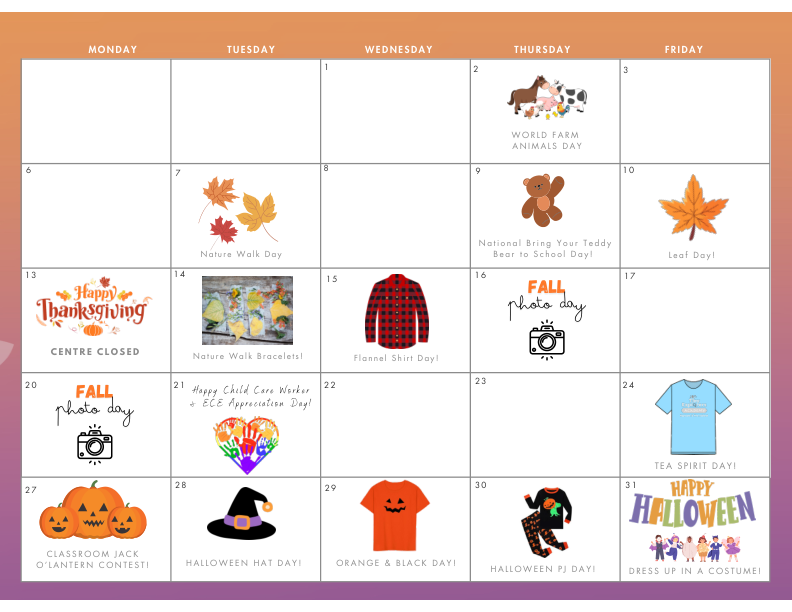

In [218]:
# -----------------------------
# Preview result (first page)
# -----------------------------

doc_preview = pymupdf.open(output_pdf)
page = doc_preview[0]
pix = page.get_pixmap()
pil_image = pix.pil_image()
pil_image